# Tutorial 6: Galactic Binaries & RJMCMC

In the sixth tutorial, we will examine Galactic Binary waveforms. We will then use them in fixed-dimensional MCMC and then in RJMCMC. We use RJMCMC to perform model selection on the number of sources in the data. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lisatools.utils.constants import *
from copy import deepcopy  # can be useful
from lisatools.utils.constants import *
from lisatools.sensitivity import get_sensitivity

## Task 1: Build and plot a Galacic Binary waveform using `GBGPU`

We will start by generating Galactic Binary waveforms with `GBGPU`. Pick reasonable parameters, build a waveform and plot it against the LISA A channel TDI Sensitivity Curve (`A1TDISens`) in the characteristic strain representation. You can access the information after waveform generation as attributes on the class. This may be updated in the future.

Useful documentation:
* [GBGPU](https://mikekatz04.github.io/GBGPU/html/user/main.html#gbgpu.gbgpu.GBGPU)

In [2]:
# imports
from gbgpu.gbgpu import GBGPU

In [3]:
gb = GBGPU()

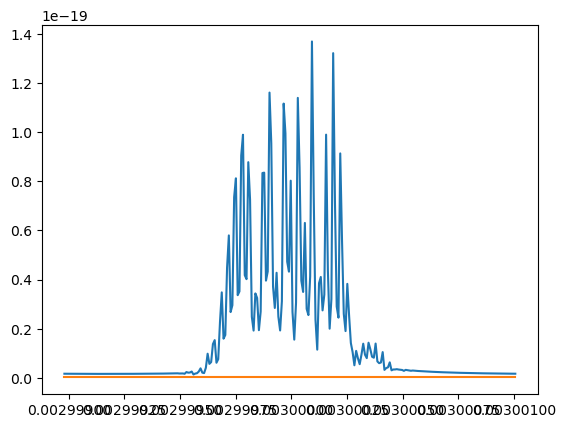

In [4]:
amp = 2e-23  # amplitude
f0 = 3e-3  # f0
fdot = 7.538331e-18  # fdot
fddot = 0.0 # fddot
phi0 = 0.1  # initial phase
inc = 0.2  # inclination
psi = 0.3  # polarization angle
lam = 0.4  # ecliptic longitude
beta = 0.5  # ecliptic latitude

Tobs = 4 * YRSID_SI
    
gb.run_wave(amp, f0, fdot, fddot, phi0, inc, psi, lam, beta, N=256)  # T=Tobs, oversample=4)
plt.plot(gb.freqs[0], gb.freqs[0] * np.abs(gb.A[0]))
plt.plot(gb.freqs[0], get_sensitivity(gb.freqs[0], sens_fn="A1TDISens", return_type="char_strain"))


## Task 2: Run an MCMC over a single GB source

Run a fixed-dimensional MCMC run with a chosen GB source. Fix the sky location for now to simplify the problem computationally (this is especially important for the next section on RJ with GBs). So, you will sample over 6 of the 8 parameters. Discuss or think about reasonable priors for these parameters and how you would determine that. For simplicity, we recommend using tightly (but not too tightly) bound uniform distributions for this example setup.

There is a faster `get_ll` method on the `GBGPU` class. However, it may be easier to use the full `AnalysisContainer` setup. This will make the RJ part more straight forward, but is not actually ideal for fixed-dimensional MCMC on GBs. 

After the run is complete, plot the posterior distribution with `chainconsumer` or `corner`. 

In [5]:
#imports
from eryn.prior import uniform_dist, ProbDistContainer

In [6]:
priors = {"gb": ProbDistContainer({
    0: uniform_dist(1e-23, 1e-21),
    1: uniform_dist(0.00299995, 0.00300005),
    2: uniform_dist(1e-18, 1e-17),
    3: uniform_dist(0.0, 2 * np.pi),
    4: uniform_dist(0.0, np.pi),  # should be over cosine of inclination, but this is simpler for examples
    5: uniform_dist(0.0, np.pi)
})}
lam = 4.13
beta = -0.15

# [lam, beta] of galactic center
default_values = np.array([lam, beta])


In [7]:
from lisatools.analysiscontainer import AnalysisContainer
from lisatools.datacontainer import DataResidualArray
from lisatools.sensitivity import AE1SensitivityMatrix

In [8]:
N_wave = 256
def like_wrap(x, analysis1, data, fd, Tobs, dt, default_values):
    input_parameters = np.zeros(9)
    input_parameters[np.array([0, 1, 2, 4, 5, 6])] = x
    input_parameters[np.array([7, 8])] = default_values
    # print(input_parameters)
    gb.run_wave(*input_parameters, T=Tobs, dt=dt, N=N_wave)  # T=Tobs, oversample=4)
    
    A = gb.A[0]
    E = gb.E[0]
    # print(A[::100], check[0][::100])
    # print(gb.freqs[0][::100], check_freqs[::100])

    start_ind = int(gb.freqs[0][0] / df)
    template = DataResidualArray(np.array([A, E]), f_arr=gb.freqs[0])
    data_tmp = DataResidualArray(data[:, start_ind:start_ind + N_wave], f_arr=fd[start_ind:start_ind + N_wave])
    sens_mat = AE1SensitivityMatrix(data_tmp.f_arr)
    analysis = AnalysisContainer(data_tmp, sens_mat)
    # fig, ax = data_tmp.loglog()
    # print(data_tmp.shape)
    # plt.show()
    # template.loglog()
    # plt.show()
    ll = analysis.template_likelihood(template)
    return ll

In [9]:
injection_params = np.array([
    amp, 
    f0,
    fdot,
    0.0,
    phi0,
    inc,
    psi,
    lam,
    beta
])
print(injection_params)

Tobs = YRSID_SI
dt = 5.0
N = int(Tobs / dt)
Tobs = N * dt
df = 1 / Tobs
# TODO: fix DataREsidualArray frequency check error here with df=
f_arr = np.arange(0.0, 1/(2 * dt) + df, df)
data_orig = np.asarray(gb.inject_signal(*injection_params, T=Tobs, dt=dt, N=N_wave))
data = DataResidualArray(data_orig.copy(), f_arr=f_arr)
sens_mat = AE1SensitivityMatrix(f_arr)
analysis = AnalysisContainer(data, sens_mat)

[ 2.000000e-23  3.000000e-03  7.538331e-18  0.000000e+00  1.000000e-01
  2.000000e-01  3.000000e-01  4.130000e+00 -1.500000e-01]


/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:83: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:85: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:87: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:92: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:94: RuntimeWarning: invalid value encountered in multiply
  Soms_nu = Soms_d * (2.0

In [10]:
sampling_injection_params = np.array([
    amp,
    f0,
    fdot,
    phi0,
    inc,
    psi
])
print(f0)
like_wrap(sampling_injection_params, analysis, data_orig, analysis.data_res_arr.f_arr, Tobs, dt, default_values)

0.003


-0.0

In [11]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State

In [12]:
ndims = {"gb": 6}
nwalkers = 24
ntemps = 10
sampler = EnsembleSampler(
    nwalkers,
    ndims, 
    like_wrap,
    priors,
    branch_names=["gb"],
    args=(analysis, data_orig, analysis.data_res_arr.f_arr, Tobs, dt, default_values),
    tempering_kwargs=dict(ntemps=10),
    nleaves_max={"gb": 1},
)

In [13]:
start_state = State({"gb": priors["gb"].rvs(size=(ntemps, nwalkers, 1))})

In [14]:
nsteps = 2000
sampler.run_mcmc(start_state, nsteps, burn=1000, progress=True)

100%|███████████████████████████████████████| 2000/2000 [05:56<00:00,  5.61it/s]


In [15]:
from chainconsumer import Chain, ChainConsumer
import pandas as pd

Parameter fdot in chain 1 is not constrained
Parameter phi0 in chain 1 is not constrained
Parameter inc in chain 1 is not constrained
Parameter psi in chain 1 is not constrained


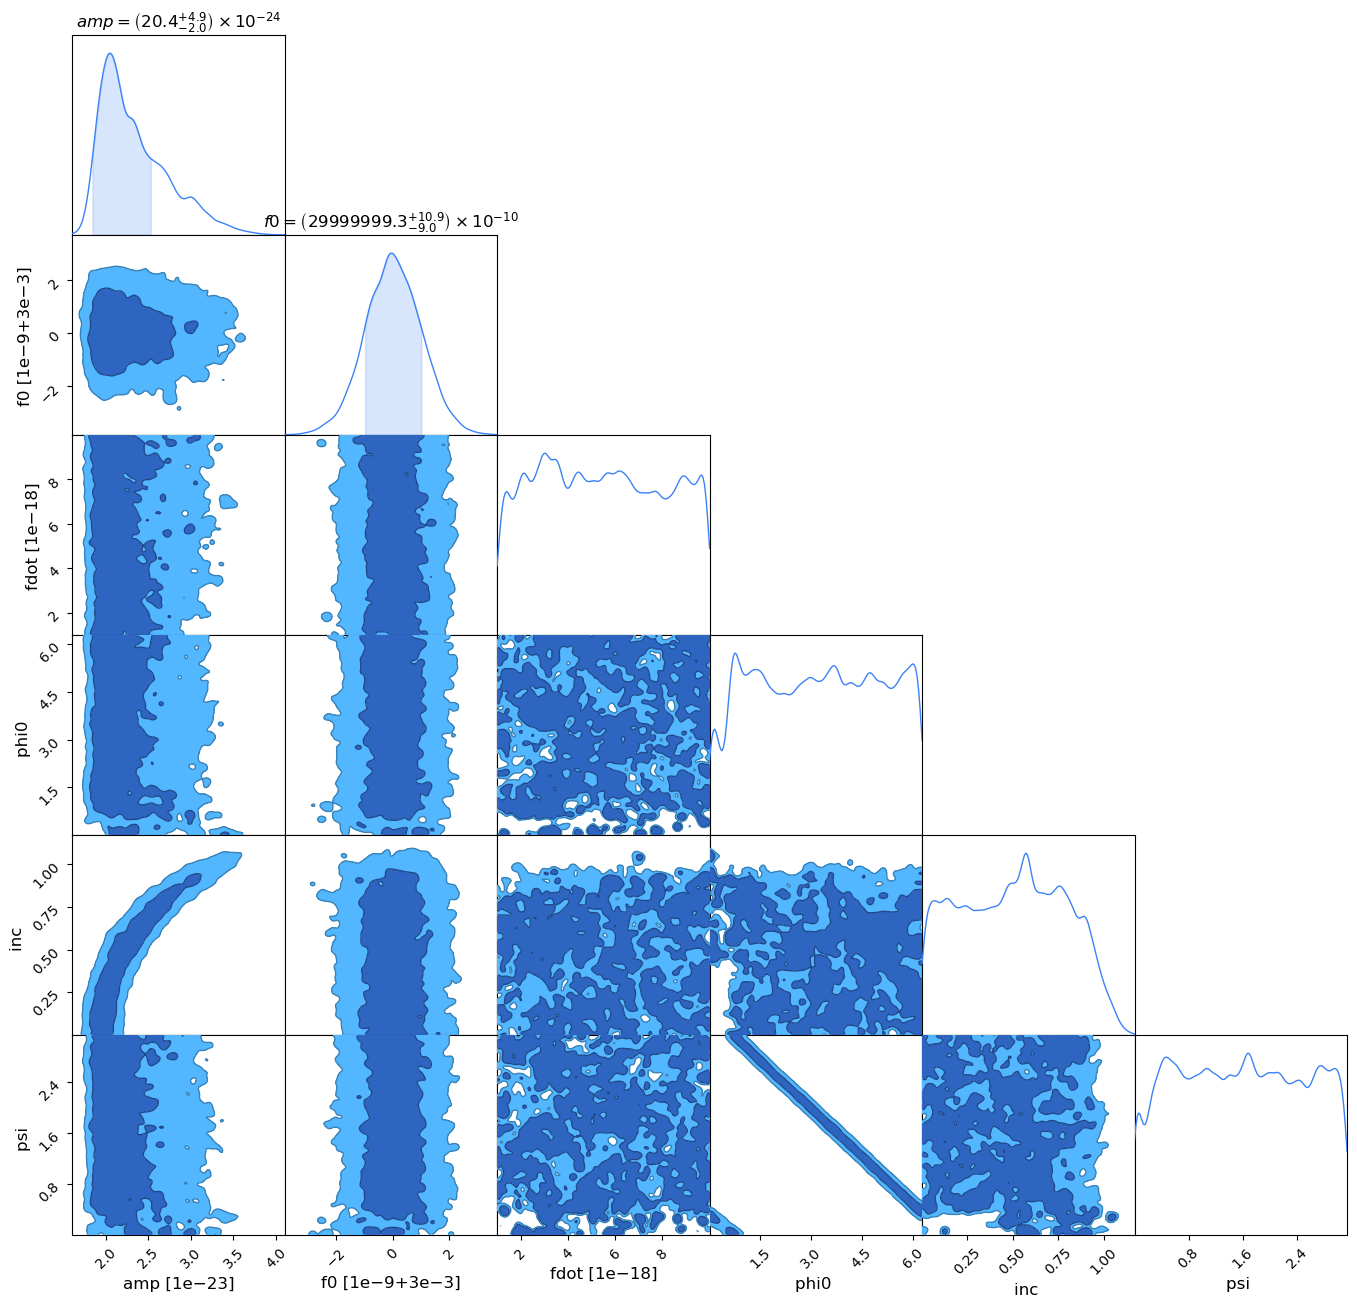

In [16]:
cold_chain = sampler.get_chain()["gb"][:, 0, :, 0].reshape(-1, 6)
c = ChainConsumer()

df1 = pd.DataFrame({name: val for name, val in zip(["amp", "f0", "fdot", "phi0", "inc", "psi"], cold_chain.T)}) 
c.add_chain(Chain(samples=df1, name=str(1)))
fig = c.plotter.plot()

## Task 3: RJ with GBs

Our final task will be to run RJMCMC on a few close Galactic Binaries. The key component here is the "global" Likelihood function. Work to build a function that takes from Eryn and adjustable length array of templates to be summed into a global template prior to the Likelihood computations. This will be a bit tedious, but is very important for understanding this process. 

There is another nuance in this problem that must be dealt with to get this all to work. In the fixed-dimensional case with one binary, the default stretch proposal is effectively invariant to the scale along each dimension as there is no mixing of dimensional information when making a  proposal, $\vec{Y} = \vec{X}_j + z\left(\vec{X}_i - \vec{X}_j\right)$. The default `GaussianMove` that we used in tutorial 5 requires an inversion of the covariance matrix. If we sample in the parameters we used above ($A$, $f_0$, $\dot{f}$, etc.), the scale differences between parameters will cause numerical issues with matrix inversion and multiplication. 

There is a small variety of ways to deal with this. Here are two possibilities:

1) You can log scale and reduce each parmeter so they are all of order 1. This would involve changing the priors and making sure you include this conversion in your Likelihood function. You can use `eryn.utils.TransformContainer` to do this conversion if you would like.
2) You can create your own proposal where you assume a diagonal covariance and generate the information yourself. I have chosen to take this route for this example. **Hint**: the Eryn tutorial has an example of this. 

If you really want to get fancy: 

In the setup described, every source that currently has `inds=True` will be moved together. That means, if a given walker has 5 sources, all 5 sources' parameters will change at the same time. This can hurt the acceptance fraction of these moves. In reality, you may want to use Gibbs sampling to sample one or a few sources at once. You can accomplish this using the `gibbs_sampling_setup` kwarg for `eryn.moves.Move`. 

Useful documentation:

* [MHMove](https://mikekatz04.github.io/Eryn/html/user/moves.html#eryn.moves.MHMove)
* [TransformContainer](https://mikekatz04.github.io/Eryn/html/user/utils.html#eryn.utils.TransformContainer)
* [Move](https://mikekatz04.github.io/Eryn/html/user/moves.html#eryn.moves.Move)

If you can run the sampler and confirm the Likelihoods are working, then consider this completed. The time alloted for the tutorial and the overall setup needed to run this RJ setup correclty require a lot more runtime for reasonable results. So, you can plot what comes out, but it will become more accurate as your run the sampler longer. 

In [17]:
# imports
from eryn.moves import MHMove

In [18]:
def fill_template(template, A, E, freqs, Tobs, dt):
    for i in range(A.shape[0]):
        start_ind = gb.start_inds[i]
        end_ind = start_ind + N_wave
        
        assert end_ind - start_ind == gb.freqs.shape[1]
        template[0, start_ind:end_ind] += A[i]
        template[1, start_ind:end_ind] += E[i]

def generate_global_template(template, params_all, Tobs, dt):
    gb.run_wave(*params_all.T, T=Tobs, dt=dt, N=N_wave)  # Te=Tobs, oversample=4)
    fill_template(template, gb.A, gb.E, gb.freqs, Tobs, dt)
    
def global_log_likelihood(params_all, analysis, Tobs, dt, default_values):
    input_parameters = np.zeros((params_all.shape[0], 9))
    input_parameters[:, np.array([0, 1, 2, 4, 5, 6])] = params_all
    input_parameters[:, np.array([7, 8])] = default_values
    # print(input_parameters)
    
    template = np.zeros_like(analysis.data_res_arr[:])

    generate_global_template(template, input_parameters, Tobs, dt)
    template_in = DataResidualArray(template, f_arr=f_arr)
    ll = analysis.template_likelihood(template_in)
    return ll

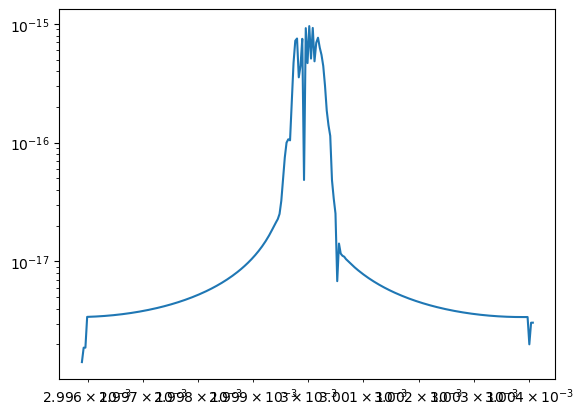

In [19]:
injection_params_all = priors["gb"].rvs(size=5)
input_parameters = np.zeros((injection_params_all.shape[0], 9))
input_parameters[:, np.array([0, 1, 2, 4, 5, 6])] = injection_params_all
input_parameters[:, np.array([7, 8])] = default_values
data = np.zeros((2, len(f_arr)), dtype=complex)

generate_global_template(data, input_parameters, Tobs, dt)
inds = np.where(data[0])
plt.loglog(f_arr[inds], np.abs(data[0][inds]))

In [20]:
data_arr = DataResidualArray(data, f_arr=f_arr)
sens_mat = AE1SensitivityMatrix(f_arr)
analysis = AnalysisContainer(data_arr, sens_mat)

/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:83: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:85: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:87: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:92: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:94: RuntimeWarning: invalid value encountered in multiply
  Soms_nu = Soms_d * (2.0

In [21]:
class NonScaledDiagonalGaussianMove(MHMove):
    def __init__(self, cov_all, *args, **kwargs):

        for branch_name, cov in cov_all.items():
            assert isinstance(cov, np.ndarray) and cov.ndim == 1

        self.cov = cov_all
        super(NonScaledDiagonalGaussianMove, self).__init__(*args, **kwargs)
        
    def get_proposal(self, branches_coords, random, branches_inds=None, **kwargs):

        assert branches_inds is not None
        new_points = {}
        for name, cov in self.cov.items():
            assert name in branches_coords
            coords = branches_coords[name]
            inds = branches_inds[name]
            
            ntemps, nwalkers, nleaves_max, ndim = coords.shape

            # generate sigma from normal distribution
            sigma = random.randn(ntemps, nwalkers)

            tmp = np.zeros_like(coords)

            tmp = coords + sigma[:, :, None, None] * cov[None, None, None, :]
            # symmetric
            new_points[name] = np.zeros_like(coords)

            # this is not necessary as the inds will remove there changes in the parent class
            # but I put it here to indicate to think about it
            new_points[name][inds] = tmp[inds]

        # symmetric
        factors = np.zeros((ntemps, nwalkers))
            
        return new_points, factors

In [22]:
nleaves_max = {"gb": 10}
nleaves_min = {"gb": 0}
ndims = {"gb": 6}

nwalkers = 14
ntemps = 12

lam = 4.13
beta = -0.15

# [lam, beta] of galactic center
default_values = np.array([lam, beta])

cov    = {"gb": np.array([1e-24, 1e-10, 1e-19, 0.01, 0.01, 0.01])}
moves = NonScaledDiagonalGaussianMove(cov)

sampler_rj = EnsembleSampler(
    nwalkers,
    ndims,
    global_log_likelihood,
    priors,
    branch_names=["gb"],
    nleaves_max=nleaves_max,
    nleaves_min=nleaves_min,
    args=(analysis, Tobs, dt, default_values),
    rj_moves=True,
    moves=moves,
    tempering_kwargs=dict(ntemps=ntemps)
)

In [23]:
start_points = {"gb": priors["gb"].rvs(size=(ntemps, nwalkers, nleaves_max["gb"]))}
inds_tmp = np.zeros((ntemps, nwalkers, nleaves_max["gb"]), dtype=bool)
inds_tmp[:, :, 1] = True

start_state = State(start_points, inds={"gb": inds_tmp})

# lp = sampler_rj.compute_log_prior(start_state.branches_coords, inds=start_state.branches_inds)
# ll = sampler_rj.compute_log_like(start_state.branches_coords, inds=start_state.branches_inds, logp=lp)
# start_state.log_prior = lp
# start_state.log_like = ll

nsteps = 10
end_state = sampler_rj.run_mcmc(start_state, nsteps, progress=True)

100%|██████████████████████████████████████████| 10/10 [28:58<00:00, 173.83s/it]
